In [22]:
# Package imports
import random
from random import randint
import time

import os
import json
import string
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contextily as cx
import warnings
import shapely
from shapely.geometry import Point, Polygon, LineString, LinearRing, box
from shapely import oriented_envelope, affinity
import math
from tqdm import tqdm
import osmnx as ox
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# prints parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [14]:
poly = gpd.read_file("polygons/london.geojson")#.to_crs(3857).buffer(3000,join_style=2).to_crs(4326))

place_name = "London, England"

# get place boundary related to the place name as a gdf
area = ox.geocode_to_gdf(place_name)
tags = {'amenity': "fast_food"}

fastfood = ox.features_from_place(place_name, tags)
fastfood = fastfood.loc[fastfood.geometry.type=='Point']

0       POINT (-0.47925 51.54638)
1       POINT (-0.34598 51.54206)
2        POINT (0.23362 51.59360)
3        POINT (0.21138 51.60041)
4        POINT (0.23449 51.59386)
                  ...            
3440    POINT (-0.39629 51.48470)
3441    POINT (-0.13937 51.42095)
3442    POINT (-0.07588 51.54589)
3443    POINT (-0.07565 51.54497)
3444    POINT (-0.07567 51.54477)
Name: geometry, Length: 3445, dtype: geometry


<Axes: >

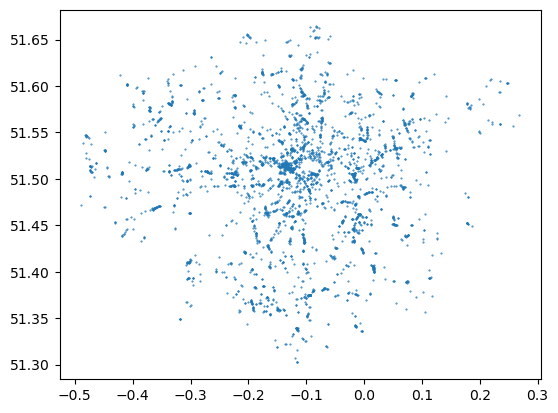

In [15]:
print(fastfood.reset_index(drop=True).geometry)
fastfood.plot(markersize=0.2)

In [97]:
def kmeans_centroids(points, clusters, seed=123):
    # The geometries of the Shapely points are converted to a numpy array for use in the kmeans algorithm
    feature_coords = np.array([[e.x, e.y] for e in points.geometry])

    # A kmeans object is created using the specified number of clusters
    kmeans = KMeans(clusters, random_state=seed)
    kmeans.fit(feature_coords)

    # The cluster centres are stored as centroids, and this list is put into a GeoDataFrame and returned
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    return gdf

def voronoi_gen(poly, generating, crs):
    
    coords = points_to_coords(generating.geometry)

    # Calculating the voronoi regions
    region_polys, region_pts = voronoi_regions_from_coords(coords, poly)

    poly_gdf = gpd.GeoDataFrame(geometry=list(region_polys.values()), crs=crs)
    poly_gdf['area'] = poly_gdf.apply(lambda row : gpd.GeoSeries(row.geometry).set_crs(27700).area, axis=1)

    return poly_gdf

print(round(len(fastfood)/4))

861


/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


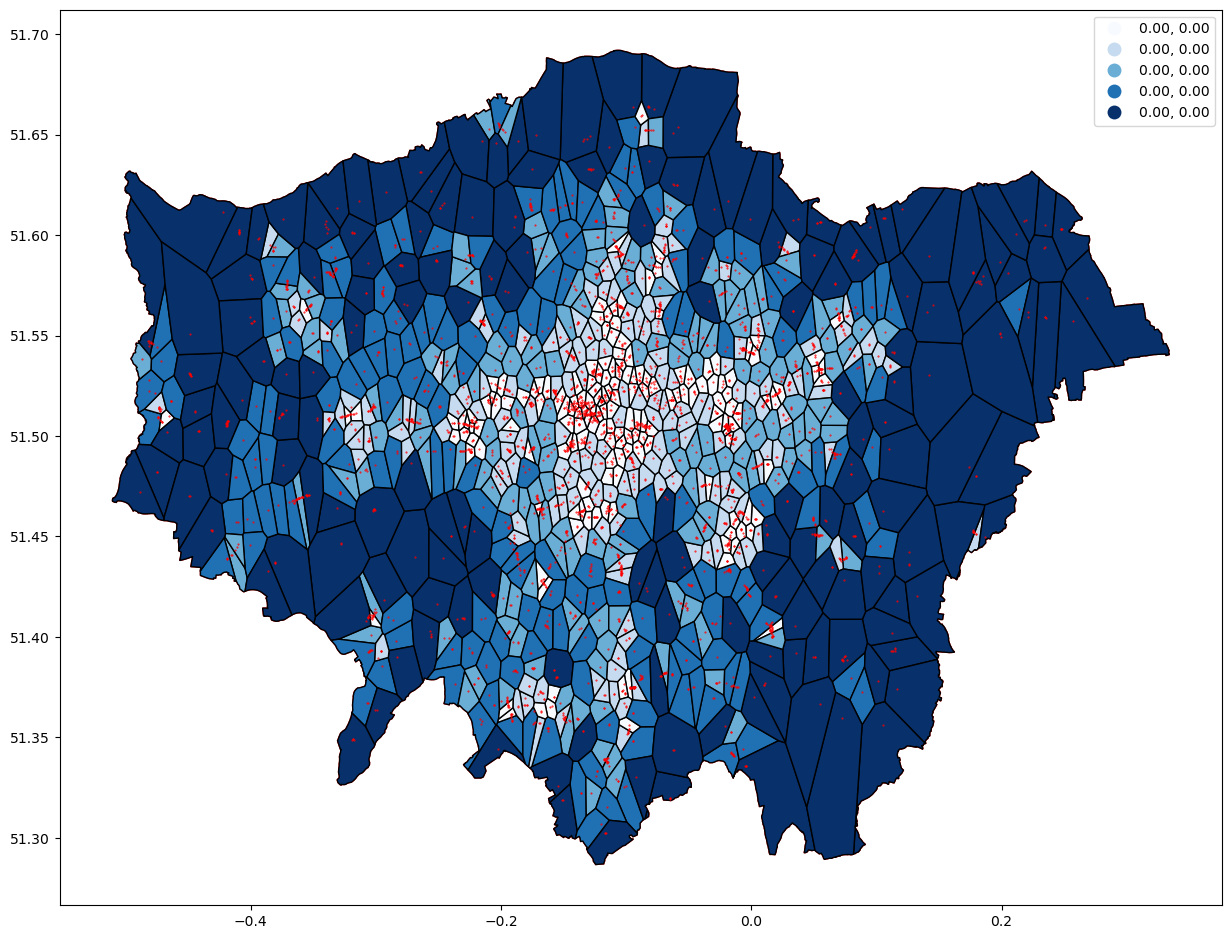

In [106]:
cluster_num = round(len(fastfood)/4)

ff_clusters = kmeans_centroids(fastfood, cluster_num, seed=np.random.randint(0,100))

fig, ax = plt.subplots(1,1, figsize=(15, 12))

# creating N voronoi polygons
ff_voronoi = voronoi_gen(poly.geometry[0], ff_clusters, poly.crs)

poly.plot(ax=ax, edgecolor='red', facecolor='none')
ff_voronoi.plot(ax=ax, column='area', legend=True, cmap='Blues', scheme='Quantiles', k=5, edgecolor='black')
fastfood.plot(ax=ax, color='red', markersize=0.2)

plt.show()
